## Load Libraries

In [107]:
import cv2
import math
import itertools
import matplotlib
import skimage.measure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from skimage.feature import greycomatrix, greycoprops
%matplotlib inline 

## Display Images

In [2]:
def display(img):
    plt.imshow (img, interpolation = 'nearest')
    _ = plt.axis(False)

## Image Path

In [3]:
img_path = "Dataset\\Apple\\0_100.jpg"

## Load Images (Original Image)

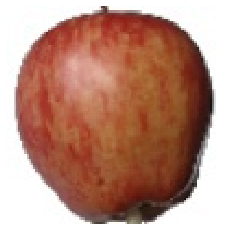

In [4]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display(img)

## Preprocessing

### Remove White Background (Thresholding)

In [5]:
def remove_background(img, threshold):
    """
    This method removes background from your image
    
    :param img: cv2 image
    :type img: np.array
    :param threshold: threshold value for cv2.threshold
    :type threshold: float
    :return: RGBA image
    :rtype: np.ndarray
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshed = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
    
    cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    mask = cv2.drawContours(threshed, cnt, 0, (0, 255, 0), 0)
    masked_data = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(cnt)
    dst = masked_data[y: y + h, x: x + w]

    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(dst_gray, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(dst)

    rgba = [r, g, b, alpha]
    dst = cv2.merge(rgba, 4)
    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGRA2RGB)

    return dst

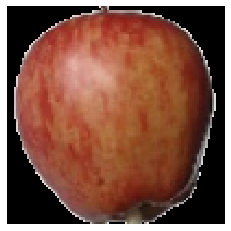

In [6]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display(img)

### Convert Image to Gray Image

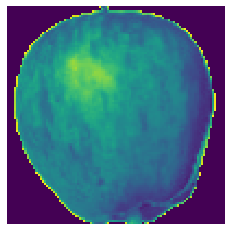

In [7]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
display(img_gray)
# cv2.imshow("Images", img_gray)
# cv2.waitKey(0)

### Apply Gaussian Blur

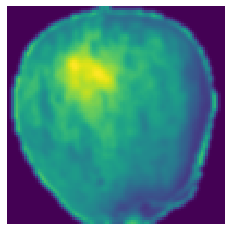

In [8]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
display(img_blur)
# cv2.imshow("Images", img_blur)
# cv2.waitKey(0)

### Draw Edges (Canny Edge)

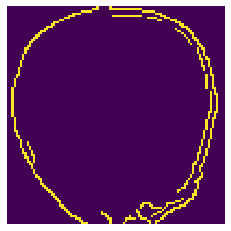

In [9]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
img_canny = cv2.Canny(img_blur, 50, 150)
display(img_canny)
# cv2.imshow("Images", img_canny)
# cv2.waitKey(0)

### Edge Dilation

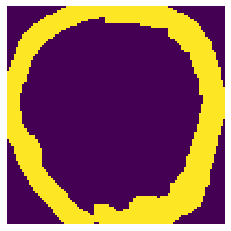

In [34]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
img_canny = cv2.Canny(img_blur, 50, 150)
kernel = np.ones((7, 7), dtype = np.uint8)
img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)
display(img_dilate)
# cv2.imshow("Images", img_dilate)
# cv2.waitKey(0)

### Crop Image from Edge

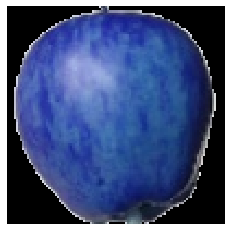

In [100]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
img_canny = cv2.Canny(img_blur, 50, 150)
kernel = np.ones((7, 7), dtype = np.uint8)
img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)

contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
roi = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    roi = img[y: y + h, x: x + w]
    
display(roi)

### Mask Crop Image

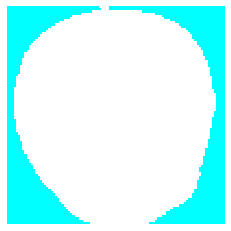

In [83]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
img_canny = cv2.Canny(img_blur, 50, 150)
kernel = np.ones((7, 7), dtype = np.uint8)
img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)

contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

roi = []

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    roi = img[y: y + h, x: x + w]
    
roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

im_floodfill = roi.copy()

h, w = roi.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255);
cv2.floodFill(im_floodfill, mask, (90,90), 255);

# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)

# Combine the two images to get the foreground.
im_out = roi | im_floodfill_inv
display(roi)
display(im_out)

### Add Contrast to Image

#### Brighten Image

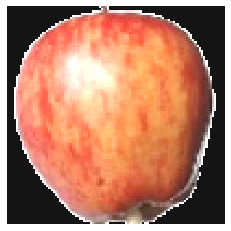

In [12]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.convertScaleAbs(img, alpha=1.5, beta=20)
display(img)

### Color Enhancement

#### Original Image

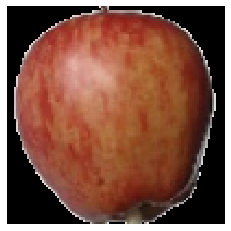

In [13]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display(img)

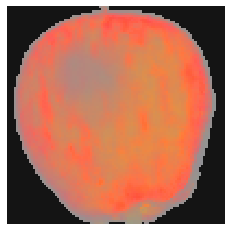

In [14]:
img = cv2.imread(img_path)
img = remove_background(img, 225)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255.0

r, g, b = cv2.split(img)
img_sum = r + g + b
CR, CG, CB = cv2.divide(r, img_sum), cv2.divide(g, img_sum), cv2.divide(b, img_sum)

img = cv2.merge((CR, CG, CB))
img = np.uint8(img * 255)
img = cv2.convertScaleAbs(img, alpha=1.5, beta=20)
display(img)

### Color Quantization

#### Convert Val To Bin

In [15]:
def convert_val_to_bin(x):
    if x >= 0 and x < 64:
        return 0
    elif x >= 64 and x < 128:
        return 64
    elif x >= 128 and x < 192:
        return 128
    else:
        return 255

#### Pipeline 1-d

In [16]:
def pipeline_1d(cv_img, convert_func):
    img_arr = np.array(cv_img)
    img_flatten = img_arr.reshape(1, -1).T
    img_squeeze = np.squeeze(img_flatten)
    img_convert = np.vectorize(convert_func)(img_squeeze)
    return img_convert

#### Original Image

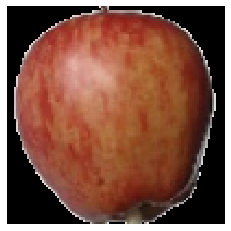

In [17]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display(img)

#### Original Image (Color Histogram)

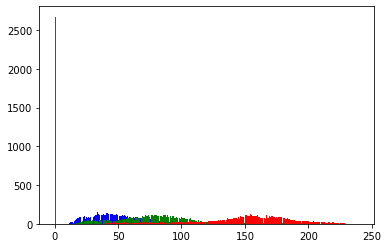

In [18]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.array(img)
img = img.reshape(-1, 3)
tmp_df = pd.DataFrame(img, columns = ["r", "g", "b"])

plt.hist(tmp_df["b"],bins=256, color="blue")
plt.hist(tmp_df["g"],bins=256, color="green")
plt.hist(tmp_df["r"],bins=256, color="red")
plt.show()

#### New Image

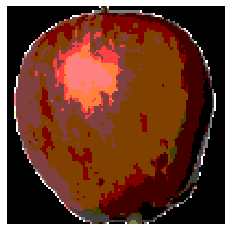

In [19]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_img = pipeline_1d(img, convert_val_to_bin)
new_img = new_img.reshape(100, 100, 3)
display(new_img)

#### New Image (Color Histogram)

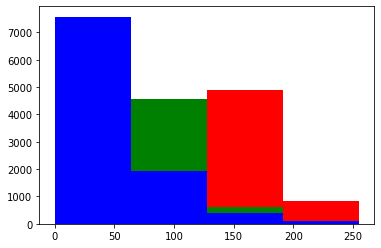

In [20]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_img = pipeline_1d(img, convert_val_to_bin)
new_img = new_img.reshape(100, 100, 3)
new_img = new_img.reshape(-1, 3)
tmp_df = pd.DataFrame(new_img, columns = ["r", "g", "b"])
plt.hist(tmp_df["r"],color="red", bins=4)
plt.hist(tmp_df["g"],color="green", bins=4)
plt.hist(tmp_df["b"],color="blue", bins=4)
plt.show()

## Texture Features

In [62]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### Get Mean Of Image

In [63]:
mean = np.mean(img_gray)
mean

73.6811

### Get Variance of Image

In [64]:
variance = np.var(img_gray)
variance

2850.7506027899994

### Get Entropy of Image

In [65]:
entropy = skimage.measure.shannon_entropy(img_gray)
entropy

5.987685345121102

### Get Gray Level Occurrence of Image

In [66]:
glcm = greycomatrix(img_gray, [2], [0], 256, symmetric = True, normed = True)

### Get Contrast of Image

In [67]:
contrast = greycoprops(glcm, prop="contrast").item()
contrast

1371.741020408163

### Get Homogeneity of Image

In [68]:
homogeneity = greycoprops(glcm, prop="homogeneity").item()
homogeneity

0.3144751929331963

### Get Correlation of Image

In [69]:
correlation = greycoprops(glcm, prop="correlation").item()
correlation

0.754684766980633

### Get Energy of Image

In [70]:
energy = greycoprops(glcm, prop="energy").item()
energy

0.2318352413540574

## Shape Features

### Original Image

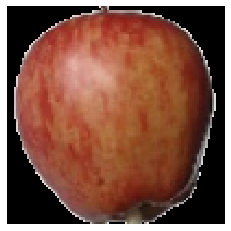

In [87]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display(img)

### Cropped Image

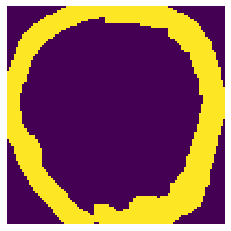

In [88]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
img_canny = cv2.Canny(img_blur, 50, 150)
kernel = np.ones((7, 7), dtype = np.uint8)
img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)
    
display(img_dilate)

### Area of image

In [96]:
contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
area = 0
for cnt in contours:
    area = cv2.contourArea(cnt)
area

8458.5

### Perimeter of Image

In [99]:
contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
peri = 0
for cnt in contours:
    peri = cv2.arcLength(cnt, True)
peri

347.03657829761505

### Moments of Image

In [113]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
img_canny = cv2.Canny(img_blur, 50, 150)
kernel = np.ones((7, 7), dtype = np.uint8)
img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)

contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mu, huMoments = [], []
for cnt in contours:
    mu = cv2.moments(cnt)
    huMoments = cv2.HuMoments(mu)

In [114]:
print("Area: ",mu['m00'])

Area:  8458.5


In [112]:
for i in range(0,7):
    huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))

In [117]:
for (i, huMoment) in enumerate(huMoments):
    print(f"huMoment {(i + 1)} : {huMoment[0]}")

huMoment 1 : 0.16043147673538338
huMoment 2 : 4.6148008593336986e-05
huMoment 3 : 2.2461601773465108e-05
huMoment 4 : 2.1455759525248393e-08
huMoment 5 : -1.2655642539608586e-14
huMoment 6 : -8.626134522210906e-11
huMoment 7 : -7.85438330132036e-15
